## 2.1 Spectral Clustering

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.pipeline import make_pipeline
from scipy.sparse.linalg import eigsh
import scipy.sparse as sps
from sklearn.metrics import adjusted_rand_score
%matplotlib inline

###  Algorithm.

In [203]:
def construct_laplacian(A, norm_type=None):
    # A - scipy.sparse.csr_matrix, [N,N]        
    # L - scipy.sparse.csr_matrix, [N, N]
    
    if sps.issparse(A):
        A = A.toarray()
    D = A.sum(axis=0)
    if norm_type is None:
        L = np.diag(D) - A
    elif norm_type == 'random_walk':
        factor = np.diag(1. / D)
        L = np.eye(len(D)) - factor.dot(A)
    elif norm_type == 'symmetrical':
        factor = np.diag(1. / np.sqrt(D))
        L = np.eye(len(D)) - factor.dot(A).dot(factor)
    else:
        raise TypeError('Unknown norm_type: "{}"'.format(norm_type))
    return L

Spectral embedding для данного графа

In [204]:
def spectral_embedding(A, num_lambda=1, norm_type=None):
 
    L = construct_laplacian(A, norm_type).astype(np.float64)
    
    eigvals, eigvectors = eigsh(L, k=1+num_lambda, which='SM')
    
    return eigvectors[:, 1:num_lambda+1]

Spectral clustering для данного графа

In [209]:
def spectral_clustering(A, n_clusters, num_lambda=1, norm_type=None):
    
    eigvectors = spectral_embedding(A, num_lambda, norm_type)
    cst = KMeans(n_clusters)
    cst.fit(eigvectors)
    return cst.predict(eigvectors)

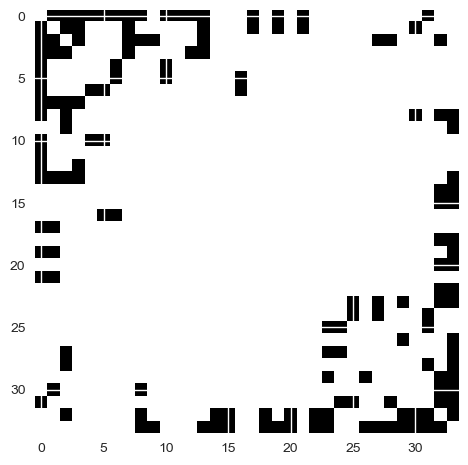

In [210]:
plt.style.use('seaborn')

A = np.load('karate_club.npy')
plt.imshow(A)

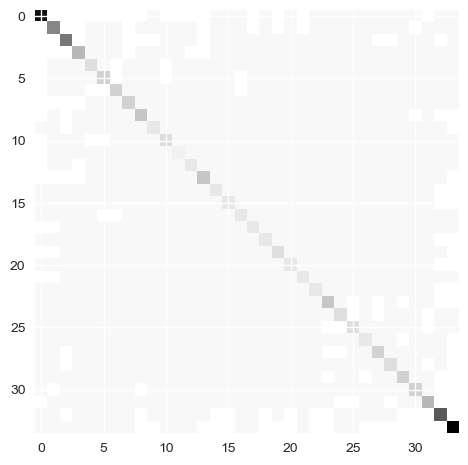

In [211]:
L = construct_laplacian(A)
plt.imshow(L)

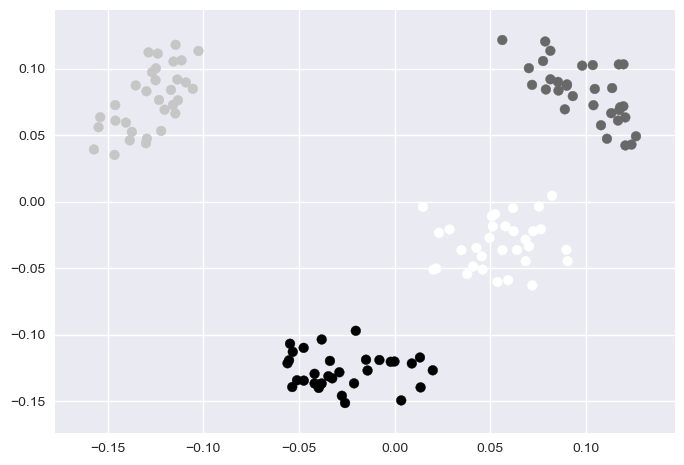

In [212]:
network = np.load('network.npy')
features = spectral_embedding(network, num_lambda=2)

labels = spectral_clustering(network, n_clusters=4, num_lambda=2)

plt.scatter(features[:, 0], features[:, 1], c=labels)

### Theoretical questions

a) From network point of view, what does Symmetric normalization do?

Симметричная нормализация $D^{-1/2}AD^{-1/2}$ матрицы $A$ перераспределяет веса на рёбрах графа, таким образом что сумма степеней вершин будет одинаковой. 

b) Under what conditions Symmetric and Random walk normalizations yield the same result?


Равенство симметричной нормализации и Random walk:
\begin{align}
D^{-1}A &= D^{-1/2}AD^{-1/2} \\
D^{-1/2}A &= AD^{-1/2}
\end{align}

Матрица $A$ симметрична, n.к. граф неориентированный. Обозначим её столбцы $a_i$.
Пусть $D^{-1/2} = D'$, и обозначим диагональные элементы $D'$ как $d_i$

\begin{align}
D^{-1/2}A &= \begin{pmatrix} d_1a_1^T \\ \vdots \\ d_na_n^T \end{pmatrix} \\
AD^{-1/2} &= (d_1a_1 ... d_na_n)
\end{align}

Откуда получаем что $$\sum_{j=1}^{n} d_i a_j = \sum_{i=1}^{n}d_i a_i$$ что означает что ненулевые $a_i$ имеют одинаковое значание $d_j$, откуда следует что связанные вершины имеют одинаковые степени. 


### Compare results of 1(a), 1(b) and 1(c) on Karate club network and artificial network (network.npy):

In [213]:
network = np.load('network.npy')
karate = np.load('karate_club.npy')

In [214]:
def plot_clusterization_results(A, n_clusters, num_lambda=1):
    to_plot = [A.copy()]
    titles = ['До кластеризации', 'Кластеризация без нормировки',
              'Кластеризация с симметричной нормализацией', 'Кластеризация с Random walk']
    for norm_type in [None, 'symmetrical', 'random_walk']:
        labels = spectral_clustering(A, n_clusters, num_lambda, norm_type)
        to_plot.append(clusterization(A, labels))
    plt.figure(figsize=(30, 15))
    plt.suptitle('Число кластеров: {}'.format(n_clusters))
    for i, mat, title in zip(range(1, 5), to_plot, titles):
        plt.subplot(4, 1, i)
        plt.imshow(mat)
        plt.title(title) 

def plot_clusterization_results_scatter(A, n_clusters):
    to_plot = []
    titles = ['До кластеризации', 'Кластеризация без нормировки',
              'Кластеризация с симметричной нормализацией', 'Кластеризация с Random walk']
    
    for norm_type in [None, 'symmetrical', 'random_walk']:
        eigvectors = spectral_embedding(A, num_lambda=2, norm_type=norm_type)
        labels = spectral_clustering(A, n_clusters, num_lambda=2, norm_type=norm_type)
        to_plot.append(eigvectors)
    plt.figure(figsize=(21, 7))
    plt.suptitle('Количество кластеров: {}'.format(n_clusters), fontsize=15)
    for i, data, title in zip(range(1, 4), to_plot, titles):
        plt.subplot(1, 3, i)
        plt.scatter(data[:, 0], data[:, 1], c=labels)
        plt.title(title)
        
def clusterization(A, labels):
    shuffle = np.argsort(labels)
    return A[shuffle, :][:, shuffle]

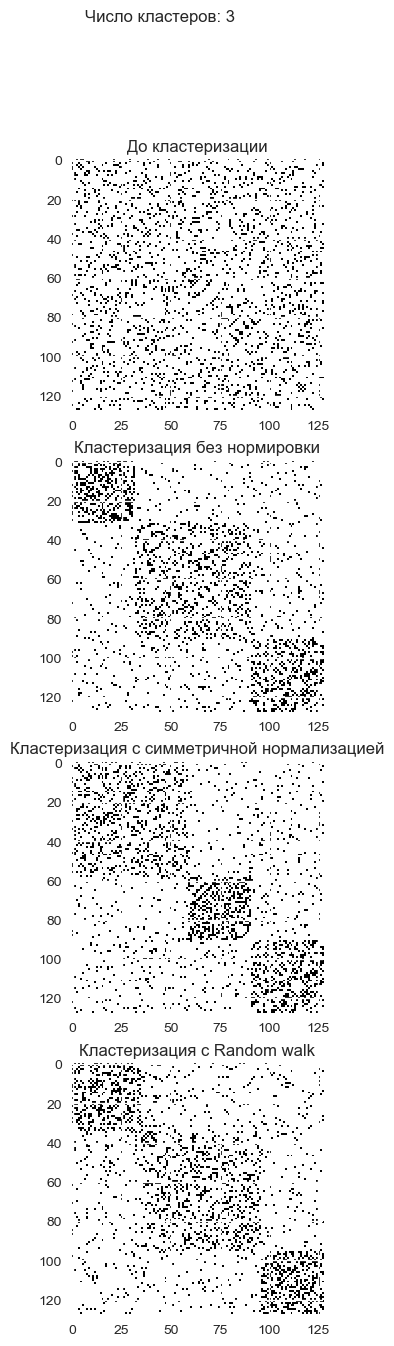

In [215]:
plt.style.use('seaborn')
plot_clusterization_results(network, 3, 1)


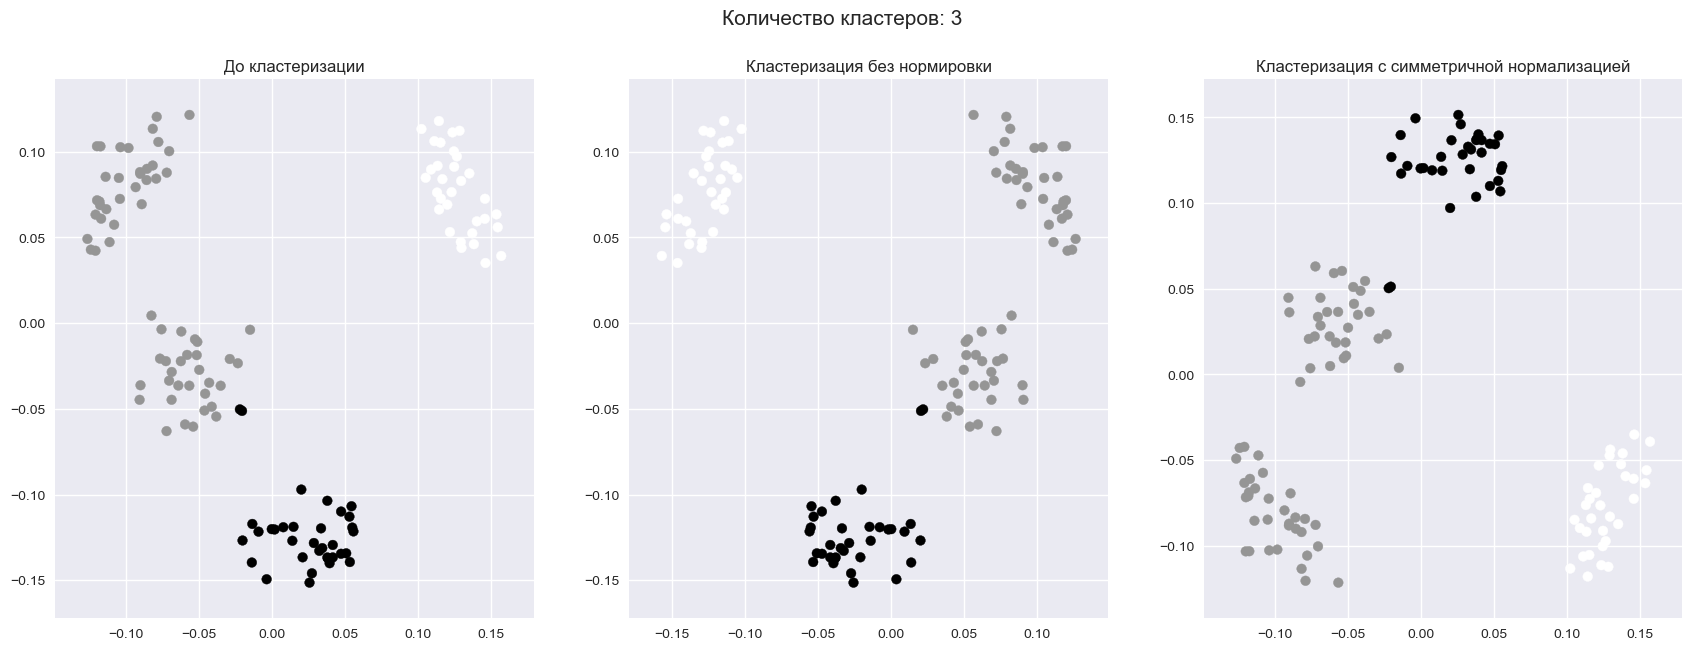

In [197]:
plot_clusterization_results_scatter(network, 3)

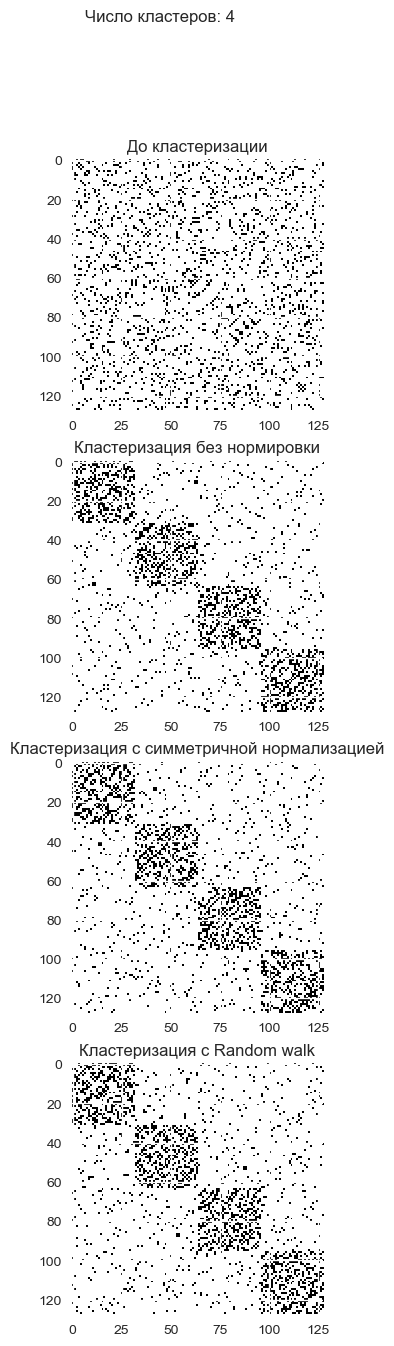

In [198]:
plot_clusterization_results(network, 4, 2)

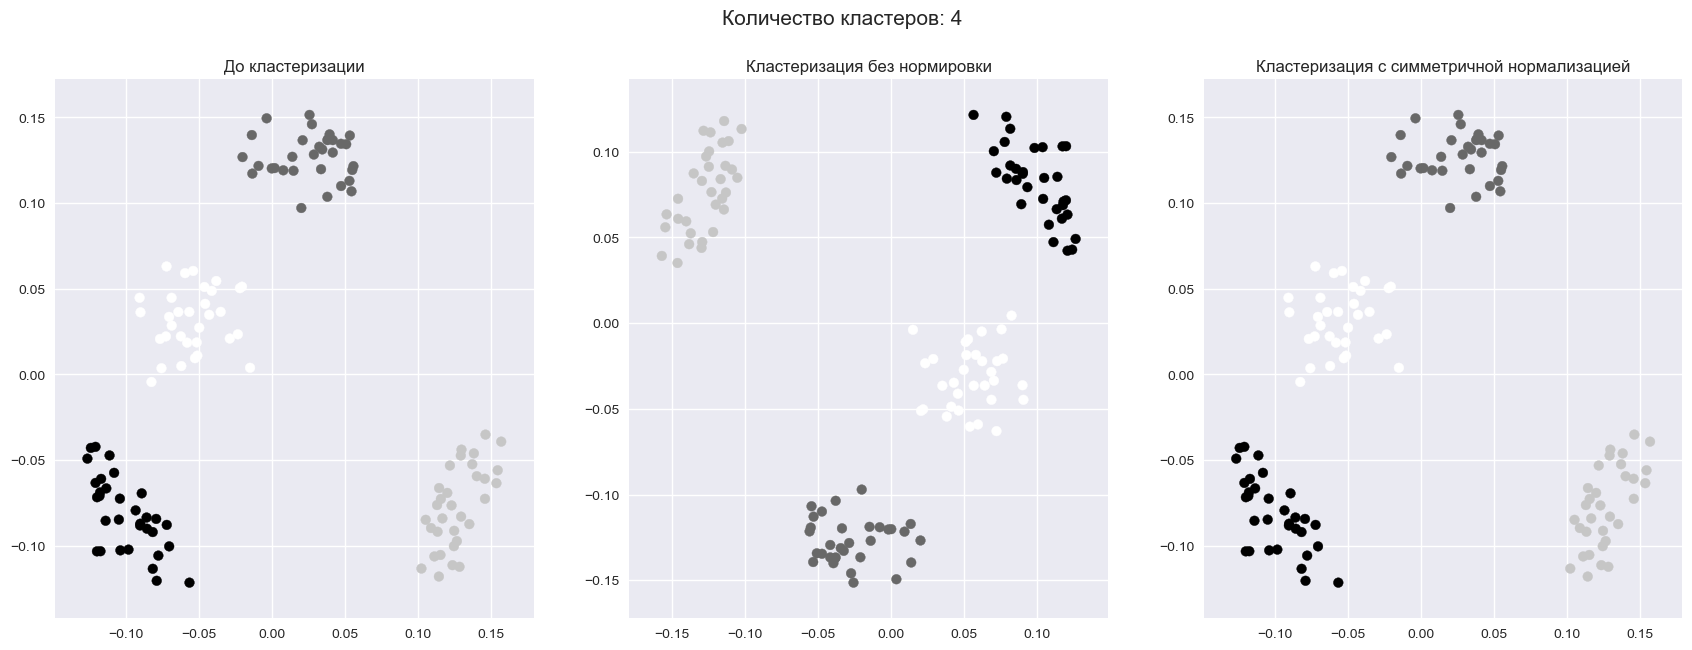

In [199]:
plot_clusterization_results_scatter(network, 4)

Осталось посмотреть Adjusted rand score. Но истинные метки нам неизвестны. На самом деле, из картинки выше видно, что кластеризуется "так, как надо". Чтобы убедиться, убедимся, что ARS между всеми способами кластеризации равен 1.0. 

In [113]:
labels = [
    spectral_clustering(network, 2, 2, None), 
    spectral_clustering(network, 2, 2, 'symmetrical'), 
    spectral_clustering(network, 2, 2, 'random_walk')
]

In [114]:
from itertools import combinations
for first, second in combinations(labels, 2):
    print(adjusted_rand_score(first, second))

1.0
1.0
1.0


#### Проделаем то же самое с karate.npy

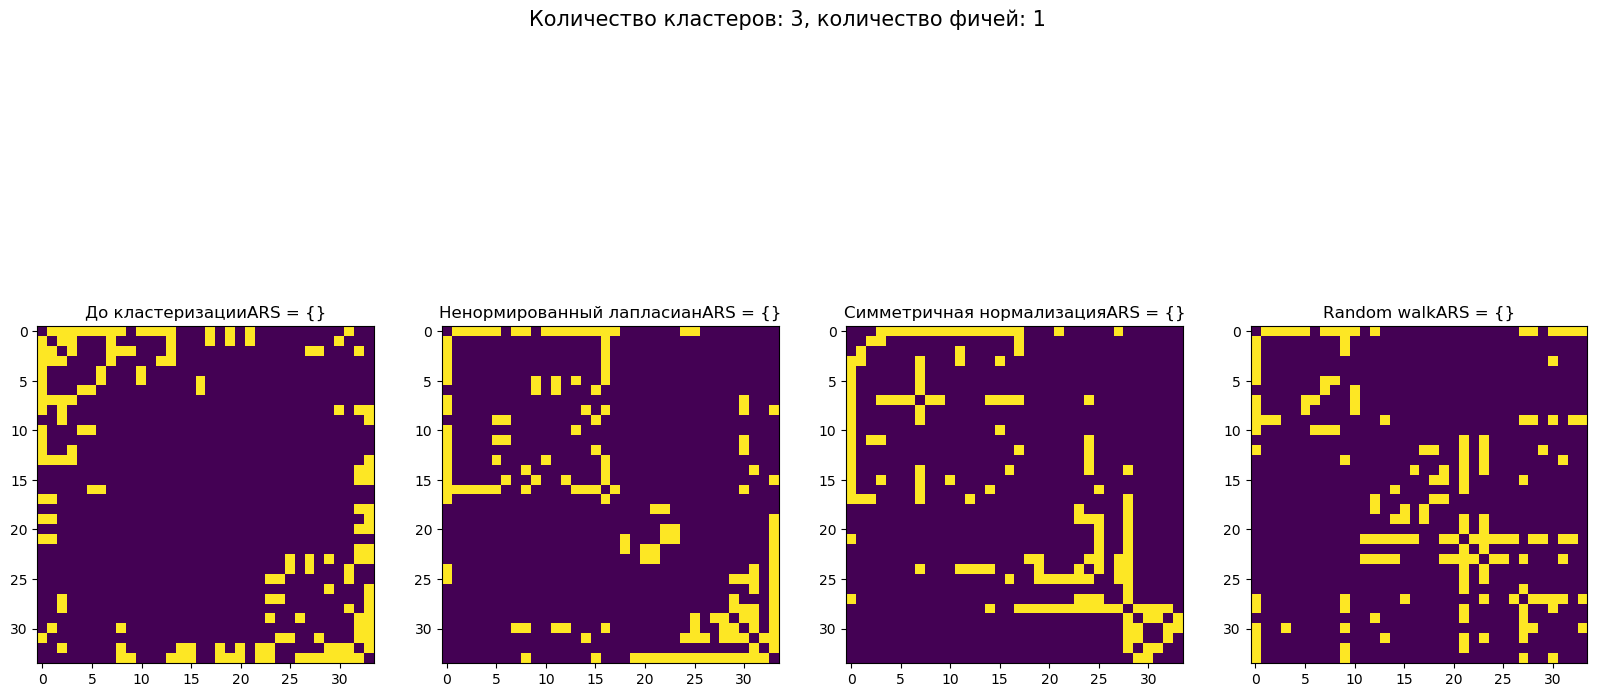

In [115]:
plot_clusterization_results(karate, 3, 1)

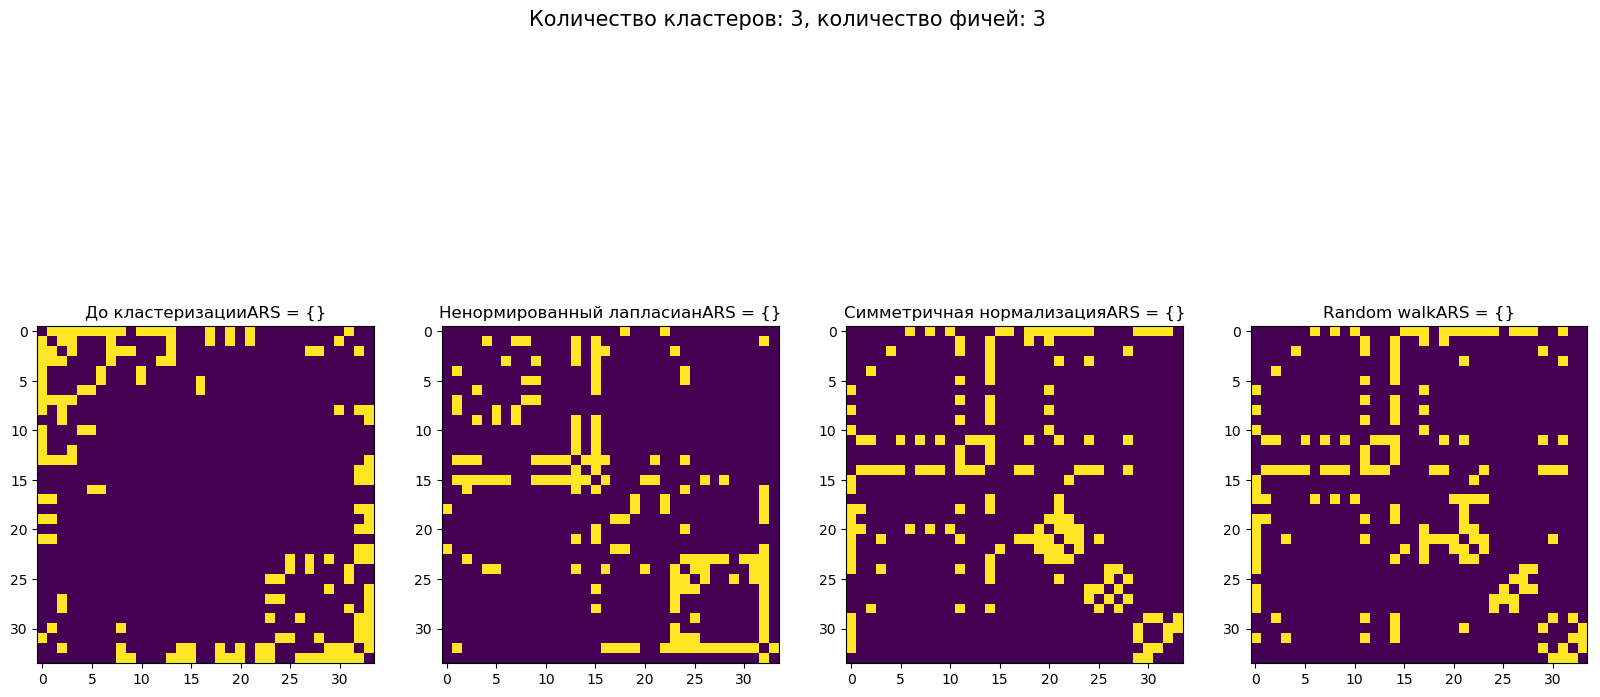

In [116]:
plot_clusterization_results(karate, 3, 3)

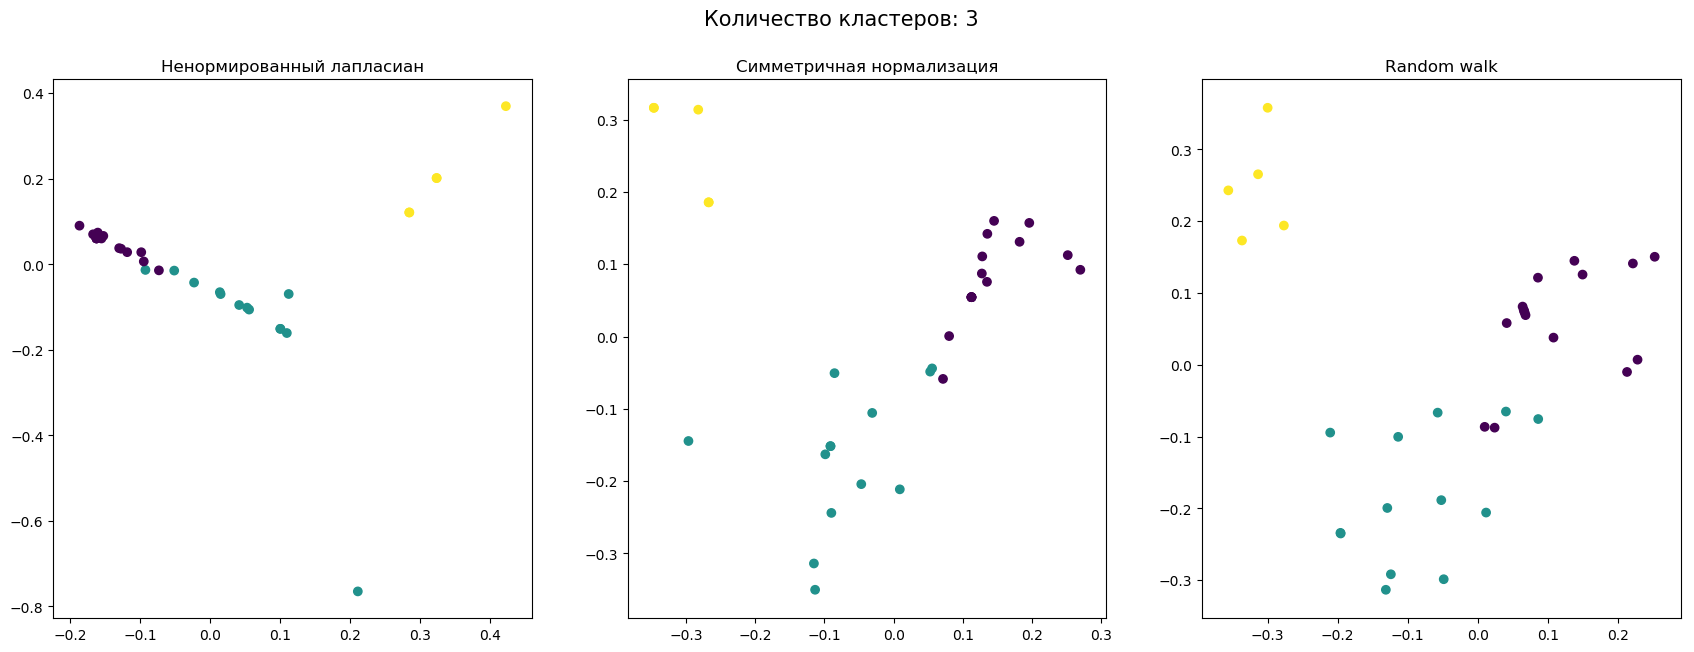

In [117]:
plot_clusterization_scatter_results(karate, 3)

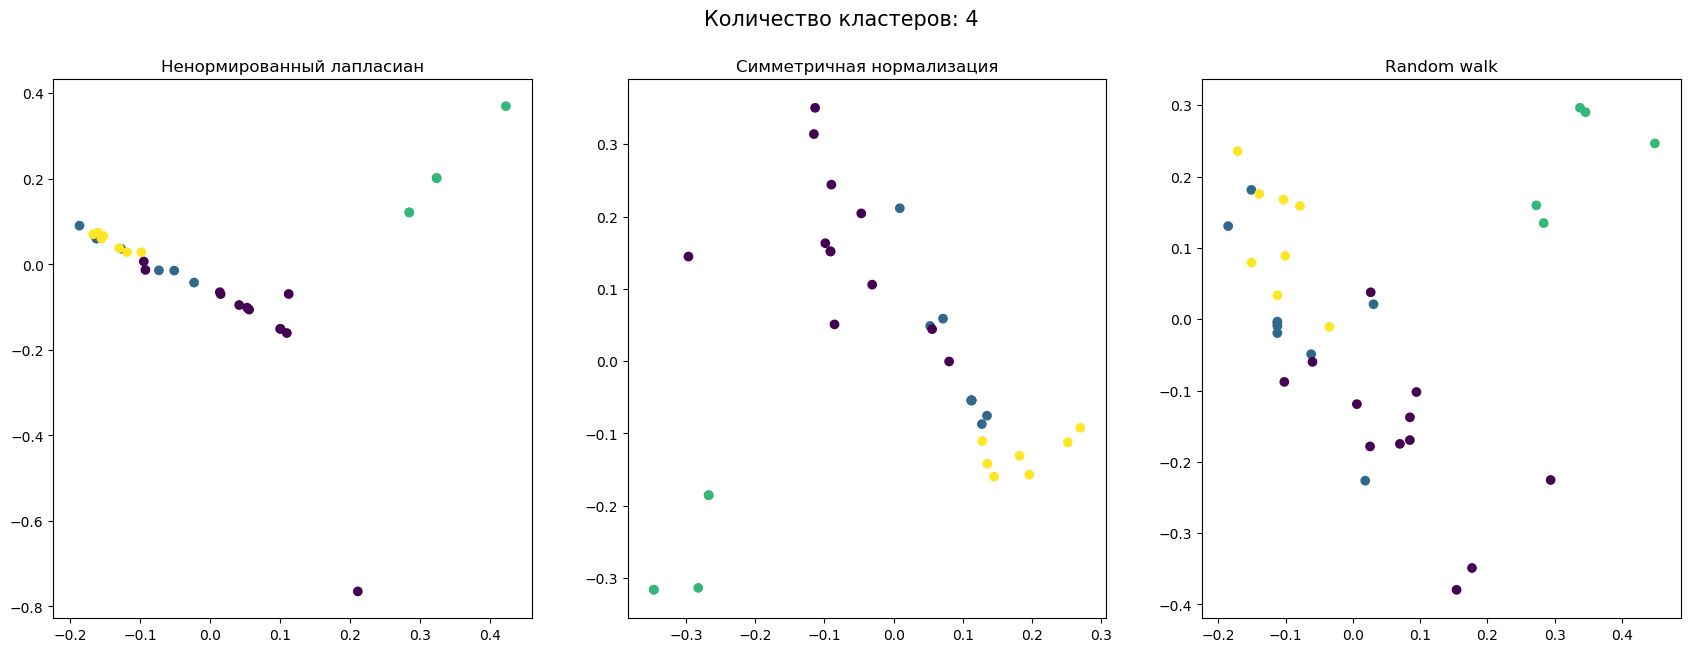

In [118]:
plot_clusterization_scatter_results(karate, 4)

К сожалению, ничего вразумительного. 

# 2. Label Propagation

In [119]:
import networkx as nx

In [120]:
def label_propagation(adj_mat, strategy='random_from_max', return_history=False, random_state=None):
    np.random.seed(random_state)
    adj_mask = adj_mat.astype(np.bool)
    labels = np.asarray(range(adj_mat.shape[0]))
    old_labels = np.zeros(adj_mat.shape[0], dtype=np.int)
    hist = []
    while np.any(labels != old_labels):
        old_labels = labels.copy()
        order = np.asarray(range(adj_mat.shape[0]))
        np.random.shuffle(order)
        for ind in order:
            colors_for_ind = labels[adj_mask[ind]]
            unique_colors, counts = np.unique(colors_for_ind, return_counts=True)
            if strategy == 'random_from_max':
                colors_with_max_weight = unique_colors[counts == counts.max()]
                chosen_color = np.random.choice(colors_with_max_weight)
            elif strategy == 'first_from_max':
                colors_with_max_weight = unique_colors[counts == counts.max()]
                chosen_color = colors_with_max_weight[0]
            elif strategy == 'random_proportional':
                chosen_color = np.random.choice(unique_colors, p=counts/counts.sum())
            else:
                raise TypeError('Unknown strategy "{}"'.format(strategy))
            labels[ind] = chosen_color
        if return_history:
            hist.append(old_labels)
    
    if return_history:
        return labels, hist
    else:
        return labels

4 clusters


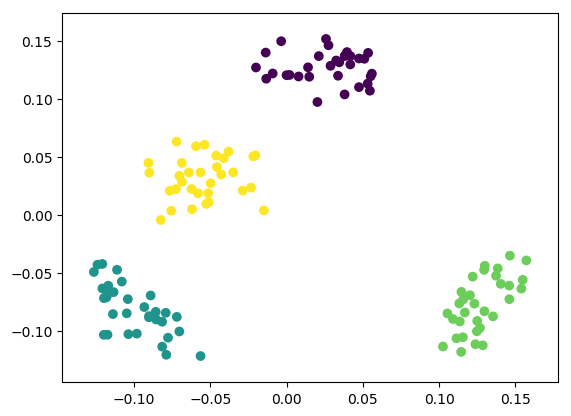

In [121]:
labels = label_propagation(network, 'random_from_max', random_state=6)
eigvectors = spectral_embedding(network, 2)
plt.scatter(eigvectors[:, 0], eigvectors[:, 1], c=labels)
print('{} clusters'.format(len(np.unique(labels))))

Если у вершины есть несколько цветов, каждому из которых соответствует максимальное число соседей, то цвет самой вершины можно определить по-разному.

* Выбрать первый из наиболее часто встречающихся цветов (first_from_max)
* Выбрать случайный цвет из наиболее часто встречающихся (random_from_max)
* Выбрать цвет с вероятностью, пропорциональной его количеству в соседях (random_proportional) 

In [122]:
def plot_results_label_propagation(mat):
    to_plot = []
    titles = ['Спектральная кластеризация', 'Случайный цвет из самых частых', 
              'Первый цвет из самых частых', 'Вероятности, пропорциональные частоте']
    labels_spectral = spectral_clustering(mat, n_clusters=4, num_lambda=2, norm_type='symmetrical')
    eigvectors = spectral_embedding(mat, num_lambda=2, norm_type='symmetrical')

    to_plot.append(labels_spectral)
    for strategy in ['random_from_max', 'first_from_max', 'random_proportional']:
        labels = label_propagation(mat, strategy)

        to_plot.append(labels)
    plt.figure(figsize=(20, 10))
    for i, labels, title in zip(range(1, 5), to_plot, titles):
        plt.subplot(1, 4, i)
        plt.title(title + '\nНайдено кластеров: {}\nARS = {}'.format(
            len(np.unique(labels)), 
            adjusted_rand_score(labels, labels_spectral)))
        img = clusterization(mat, labels)
        plt.imshow(img)
    
    plt.figure(figsize=(20, 5))
    for i, labels in zip(range(1, 5), to_plot):
        plt.subplot(1, 4, i)
        plt.scatter(eigvectors[:, 0], eigvectors[:, 1], c=labels)

#### Проведём эксперименты. Несколько раз запустим label propagation всеми тремя способами и сравним со спектральной кластеризацией.

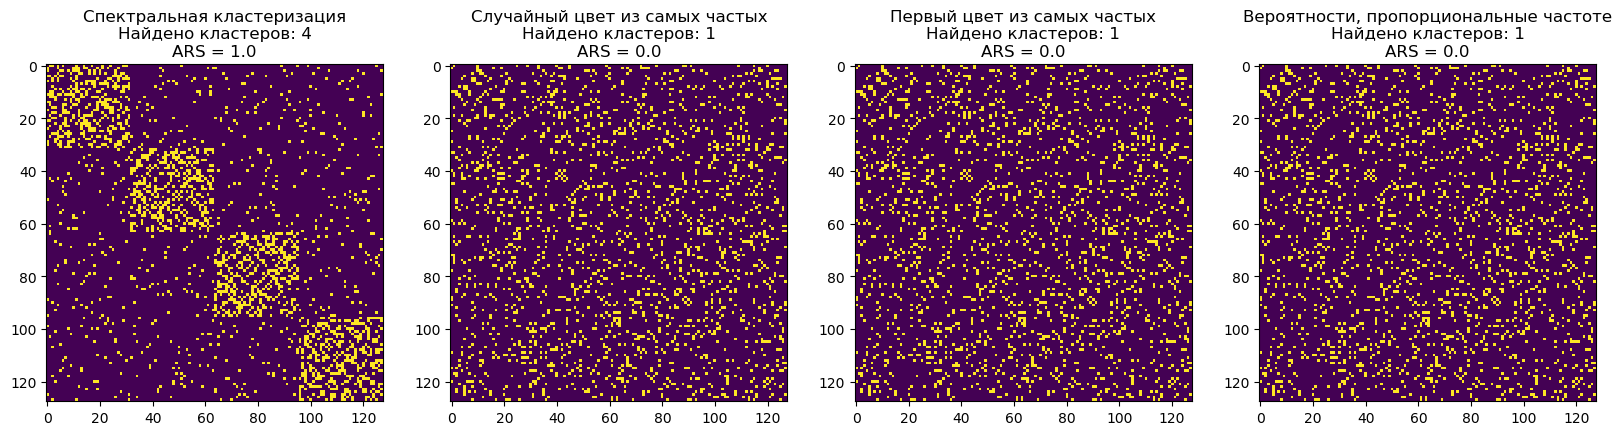

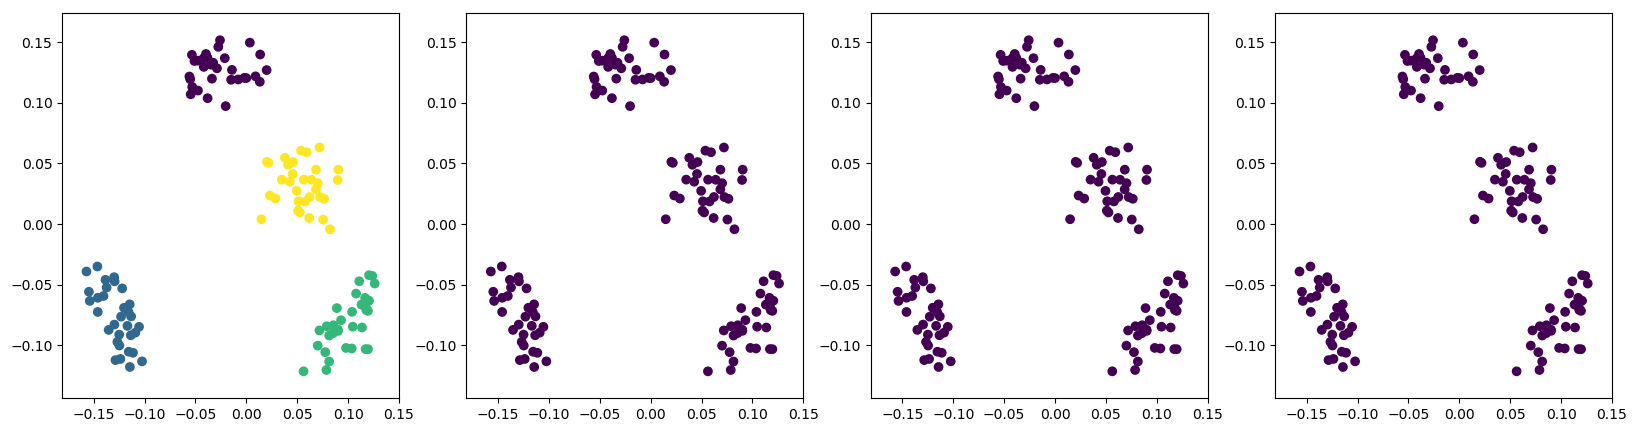

In [123]:
plot_results_label_propagation(network)

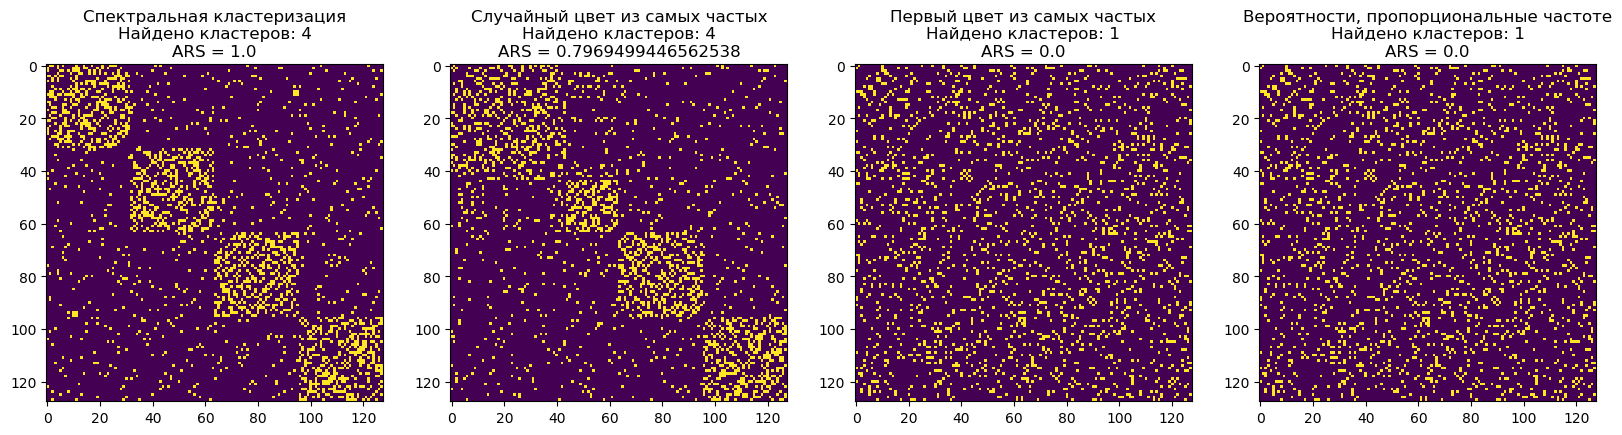

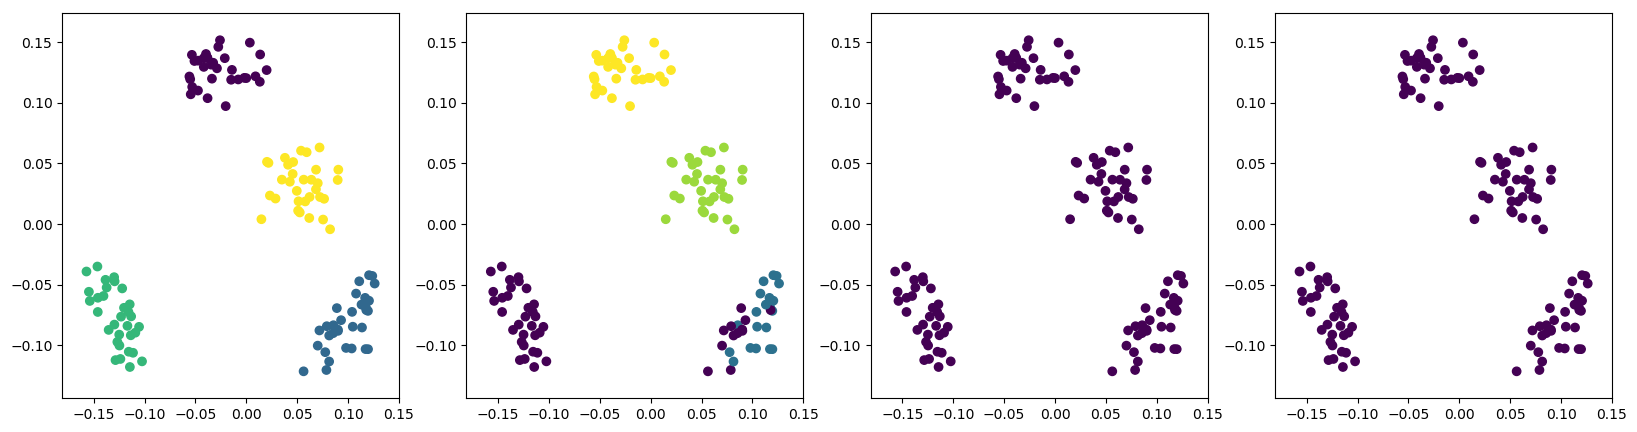

In [124]:
plot_results_label_propagation(network)

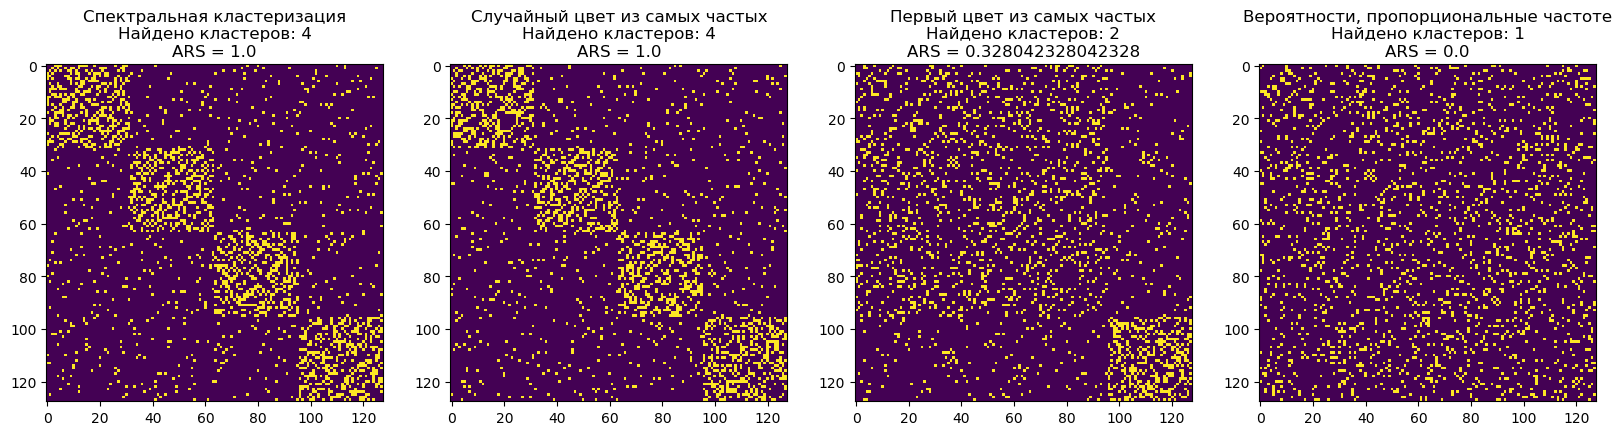

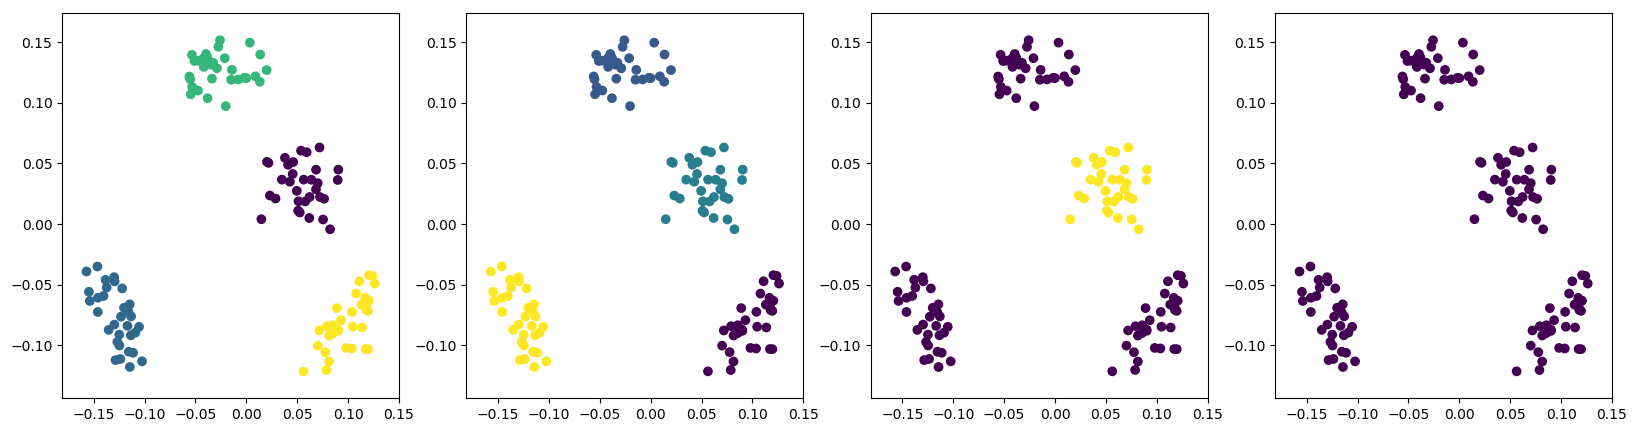

In [125]:
plot_results_label_propagation(network)

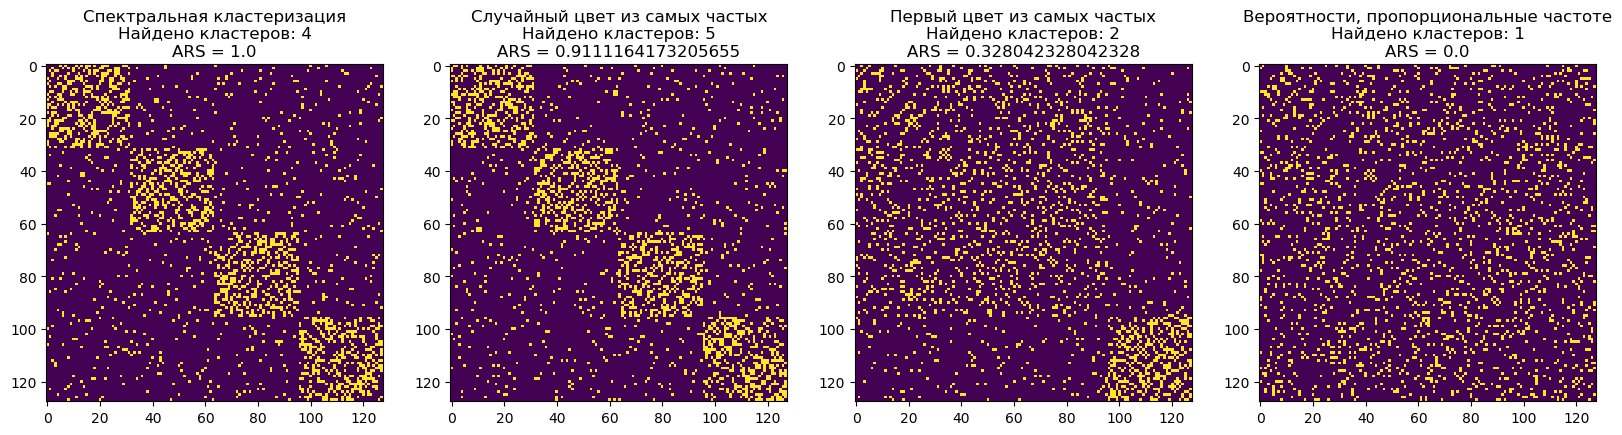

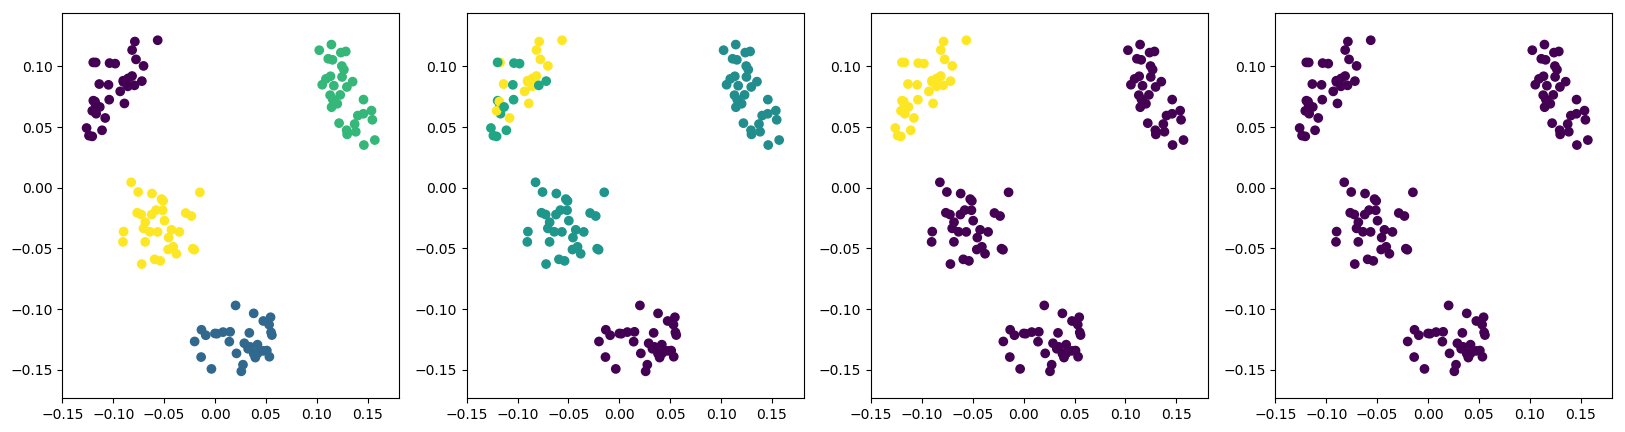

In [126]:
plot_results_label_propagation(network)

#### Выводы:

Label propagation действительно не является робастным алгоритмом (и имеет что-то общее с DBScan). От запуска к запуску получается разное количество кластеров. Однако, проведённые эксперименты показывают, что наилучшая стратегия для работы с неточностью - это выбор случайного цвета из самых частых.

# 3. Unsupervised image segmentation

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import itertools
from skimage import io
from skimage.transform import rescale
from skimage.color import rgb2gray
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Перепишем label propagation, чтобы работало со взвешенными графами.

In [128]:
def label_propagation(adj_mat, strategy='random_from_max', return_history=False, max_iterates=1000, random_state=None):
    np.random.seed(random_state)
    labels = np.asarray(range(adj_mat.shape[0]))
    old_labels = np.zeros(adj_mat.shape[0], dtype=np.int)
    hist = []
    step_count = -1
    while np.any(labels != old_labels) and step_count < max_iterates:
        step_count += 1
        old_labels = labels.copy()
        order = np.asarray(range(adj_mat.shape[0]))
        np.random.shuffle(order)
        for ind in order:
            _, inds_nonzero_weights, color_weights = sps.find(adj_mat[ind])
            colors_for_ind = labels[inds_nonzero_weights]
            unique_colors = np.unique(colors_for_ind)
            unique_color_weights = np.zeros_like(unique_colors)
            for i, color in enumerate(unique_colors):
                unique_color_weights[i] = color_weights[colors_for_ind == color].sum()

            if strategy == 'random_from_max':
                colors_with_max_weight = unique_colors[unique_color_weights == unique_color_weights.max()]
                chosen_color = np.random.choice(colors_with_max_weight)
            elif strategy == 'first_from_max':
                colors_with_max_weight = unique_colors[unique_color_weights == unique_color_weights.max()]
                chosen_color = colors_with_max_weight[0]
            elif strategy == 'random_proportional':
                chosen_color = np.random.choice(unique_colors, p=unique_color_weights/unique_color_weights.sum())
            else:
                raise TypeError('Unknown strategy "{}"'.format(strategy))
            labels[ind] = chosen_color
        if return_history:
            hist.append(old_labels)
    
    if return_history:
        return labels, hist
    else:
        return labels

#### Способы уменьшения количества рёбер:

* Отсекать рёбра с малыми весами

* Проводить соединять рёбрами только те вершины, которым соответствуют пиксели, находящиеся недалеко друг от друга

In [129]:
def build_weight_matrix(img, graph_type='full', weight_choice='inverse', img_dist_coef=0.1, 
                        eps=1e-6, radius=None, threshold=None):
    m, n = img.shape[0:2]
    if len(img.shape) == 2:
        img = img.reshape(m, n, 1)
    if graph_type == 'full':
        weights = np.zeros((m*n, m*n))
        for layer_ind in range(img.shape[2]):
            layer = img[:, :, layer_ind].flatten()
            layer_repeated = np.tile(layer, len(layer)).reshape(m*n, m*n)
            weights += (layer_repeated - layer_repeated.T)**2
        weights = 1. / (weights + np.ones((m*n, m*n)) * eps)
        weights[range(m*n), range(m*n)] = np.zeros(m*n)
        if threshold is not None:
            weights[weights < threshold] = 0.
        weights = sps.csr_matrix(weights)
    elif graph_type in ['nearest_4', 'radius']:
        weights = sps.lil_matrix((m*n, m*n))
        for i, j in itertools.product(range(m), range(n)):
            neighbors = []
            if graph_type == 'nearest_4':
                neighbors_area = [(0, -1), (-1, 0), (1, 0), (0, 1)]
            elif graph_type == 'radius':
                if radius is None:
                    raise TypeError('Please specify non None radius')
                neighbors_area = itertools.product(range(radius), range(radius))
            else:
                raise TypeError('Unknown graph type "{}"'.format(graph_type))
            for shift_i, shift_j in neighbors_area:
                if 0 <= i + shift_i <= m-1 and 0 <= j + shift_j <= n-1:
                    neighbors.append((i + shift_i, j + shift_j))
#             print('neigbors = {}'.format(neighbors))
            for pixel in neighbors:
                i0, j0 = pixel
                dist = np.linalg.norm((img[i, j, :] - img[i0, j0, :]))
                img_dist = np.sqrt((i-i0)**2 + (j-j0)**2)
                if weight_choice == 'inverse':
                    weights[i*n + j, i0*n + j0] = 1. / (dist + eps + img_dist_coef * img_dist)
                elif weight_choice == 'minus':
                    weights[i*n + j, i0*n + j0] = -1 - dist - img_dist_coef * img_dist
                else:
                    raise TypeError('Unknown weight choice strategy {}'.format(weight_choice))
        weights = weights.tocsr()
    return weights

def unsupervised_segmentation(img, clusterisation_algorithm, weights_strategy='rgb', graph_type='full', 
                              weight_choice='inverse', img_dist_coef=0.1, eps=1e-6, radius=None, 
                              threshold=None, **kwargs):
    if weights_strategy == 'rgb':
        weights = build_weight_matrix(img, graph_type, weight_choice, img_dist_coef, eps, radius, threshold)
    elif weights_strategy == 'gray':
        weights = build_weight_matrix(rgb2gray(img), graph_type, weight_choice, img_dist_coef, eps, radius, threshold)
    elif weights_strategy == 'separate':
        weights = [build_weight_matrix(img[:, :, i], graph_type, weight_choice, img_dist_coef, eps, radius, threshold)
                   for i in range(3)]
    else:
        raise TypeError('Unknown weights_strategy: "{}"'.format(weights_strategy))
    print('weight matrix built!')

    name_to_cluster_alg = {'label_propagation': label_propagation, 'spectral': spectral_clustering}
    if weights_strategy == 'separate':
        labels = np.array([name_to_cluster_alg[clusterisation_algorithm](layer, **kwargs) for layer in weights])
        labels = np.unique(labels, return_inverse=True, axis=1)[1]
        return labels, weights
    else:
        return name_to_cluster_alg[clusterisation_algorithm](weights, **kwargs), weights

### Посмотрим, как работают разные алгоритмы на имеющихся картинках

#### С помощью label propagation

In [130]:
apple = io.imread('./apple-704x400.jpg')
apple = rescale(apple, 0.1)
print(apple.shape)
width, height, _ = apple.shape

(40, 70, 3)


C:\Users\User\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Подсчёт расстояний по всем трём цветам

weight matrix built!
Количество кластеров: 1855
Wall time: 25 s


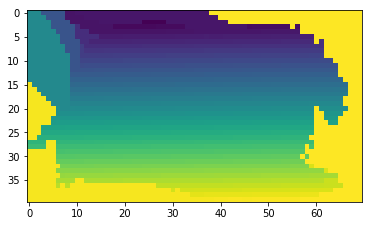

In [131]:
%%time
labels, weights = unsupervised_segmentation(apple, 'label_propagation', 'rgb', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Работа с серым изображением

weight matrix built!
Количество кластеров: 1811
Wall time: 20.6 s


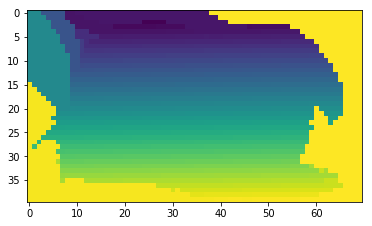

In [132]:
%%time
labels, weights = unsupervised_segmentation(apple, 'label_propagation', 'gray', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Отдельная кластеризация для каждого из трёх слоёв

weight matrix built!
Количество кластеров: 1870
Wall time: 56.4 s


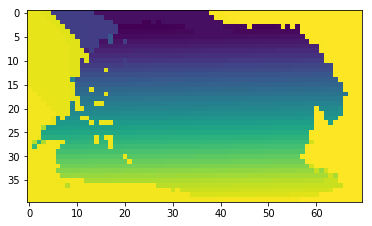

In [133]:
%%time
labels, weights = unsupervised_segmentation(apple, 'label_propagation', 'separate', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Учитывание только 4 близлежащих пикселей при подсчёте весов

weight matrix built!
Количество кластеров: 546
Wall time: 11min 7s


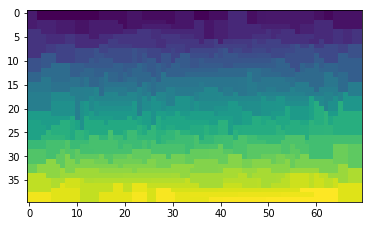

In [134]:
%%time
labels, weights = unsupervised_segmentation(apple, 'label_propagation', 'rgb', 'nearest_4', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

#### С помощью spectral clustering

Полный граф

weight matrix built!
Количество кластеров: 3
Wall time: 23.3 s


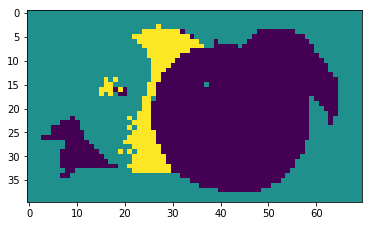

In [135]:
%%time
labels, weights = unsupervised_segmentation(apple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='full', 
                                            weight_choice='inverse', eps=1e-4, 
                                            n_clusters=3, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

weight matrix built!
Количество кластеров: 4
Wall time: 24.3 s


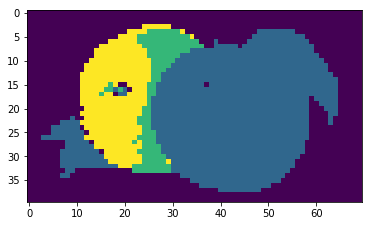

In [136]:
%%time
labels, weights = unsupervised_segmentation(apple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='full', 
                                            weight_choice='inverse', eps=1e-4, 
                                            n_clusters=4, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Ненулевые веса только для близлежащих пикселей

weight matrix built!
Количество кластеров: 4
Wall time: 30.2 s


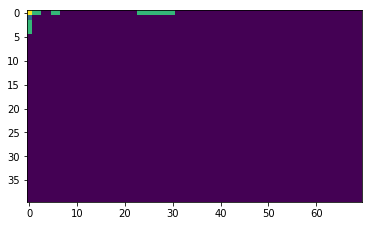

In [137]:
%%time
labels, weights = unsupervised_segmentation(apple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='radius', 
                                            weight_choice='inverse', radius=10, eps=1e-4, 
                                            n_clusters=4, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

### Теперь то же самое для картинки с ананасом

#### С помощью label propagation

In [138]:
pineapple = io.imread('./pineapple.jpg')
pineapple = rescale(pineapple, 0.1)
print(pineapple.shape)
width, height, _ = pineapple.shape

(60, 112, 3)


C:\Users\User\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Подсчёт расстояний по всем трём цветам

weight matrix built!
Количество кластеров: 4972
Wall time: 43.5 s


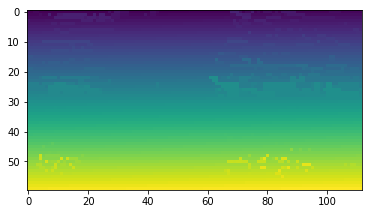

In [139]:
%%time
labels, weights = unsupervised_segmentation(pineapple, 'label_propagation', 'rgb', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Работа с серым изображением

weight matrix built!
Количество кластеров: 4591
Wall time: 58.7 s


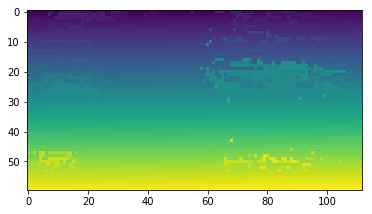

In [140]:
%%time
labels, weights = unsupervised_segmentation(pineapple, 'label_propagation', 'gray', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Отдельная кластеризация для каждого из трёх слоёв

weight matrix built!
Количество кластеров: 4944
Wall time: 2min 45s


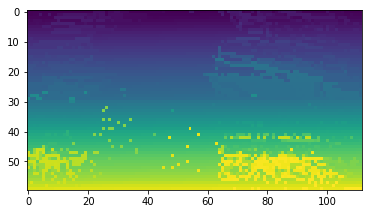

In [141]:
%%time
labels, weights = unsupervised_segmentation(pineapple, 'label_propagation', 'separate', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Учитывание только 4 близлежащих пикселей при подсчёте весов

weight matrix built!
Количество кластеров: 1762
Wall time: 26min 48s


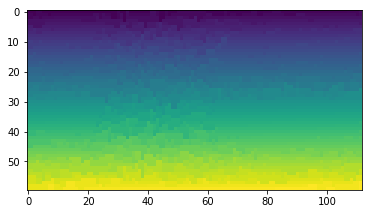

In [142]:
%%time
labels, weights = unsupervised_segmentation(pineapple, 'label_propagation', 'rgb', 'nearest_4', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

#### С помощью spectral clustering

Полный граф

weight matrix built!
Количество кластеров: 3
Wall time: 39.6 s


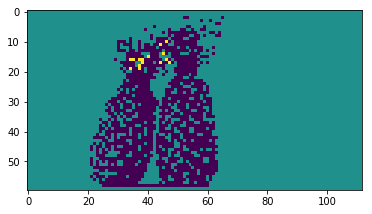

In [143]:
%%time
labels, weights = unsupervised_segmentation(pineapple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='full', 
                                            weight_choice='inverse', eps=1e-4, 
                                            n_clusters=3, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

weight matrix built!
Количество кластеров: 2
Wall time: 37.5 s


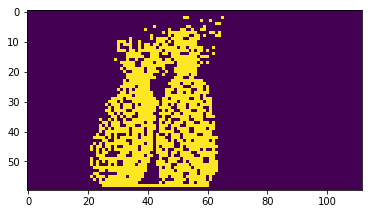

In [144]:
%%time
labels, weights = unsupervised_segmentation(pineapple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='full', 
                                            weight_choice='inverse', eps=1e-4, 
                                            n_clusters=2, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

### Выводы:

* В целом, с помощью spectral clustering получаются более адекватные картинки

* Если рассматривать граф, в котором рёбра проводятся только между близлежащими пикселами, то получится матрица смежности, у которой значения только вблизи диагонали. Разложения для таких матриц работают плохо. Так как spectral clustering основан на svd-разложении, он не работает в этом случае.

* Если строить полный граф, то label propagation будет работать очень долго. Для полных графов лучше использовать spectral clustering.

* Чем больше плотность графа, тем больше предпочтение следует отдавать spectral clustering